In [1]:
import sys
sys.path.append('../')  # To ensure utils can be imported if needed

%load_ext autoreload
%autoreload 2

In [4]:
import pickle
import os

with open("../data/eval_results/grow/probe/eval_100_depth_4_llama-3.2-3b.pkl", "rb") as f:
# with open("../data/grow/test_100_depth_4.pkl", "rb") as f:
    data = pickle.load(f)

In [5]:
data[:4]

[{'id': 0,
  'question': 'Who is the author of Burnt Offering?',
  'answer': 'Jonathan Sims',
  'complex_question_id': 0,
  'probe_answers': ['T.S. Eliot',
   'J.R.R. Tolkien',
   'J.R.R. Tolkien',
   'James Merrill',
   'C.S. Lewis',
   'J.R.R. Tolkien',
   'William Golding',
   'J.R.R. Tolkien',
   'J.R.R. Tolkien',
   'C.S. Lewis'],
  'knowledgable': False,
  'knowledge_confidence': 0.0,
  'eval_probe_results': {'probe_answers': ['T.S. Eliot',
    'J.R.R. Tolkien',
    'J.R.R. Tolkien',
    'James Merrill',
    'C.S. Lewis',
    'J.R.R. Tolkien',
    'William Golding',
    'J.R.R. Tolkien',
    'J.R.R. Tolkien',
    'C.S. Lewis'],
   'probe_answers_correct': ['No, T.S. Eliot is a different author from Jonathan Sims. They are not the same person and have written different works.',
    'No, J.R.R. Tolkien is a different author from Jonathan Sims. They are known for different works and belong to different literary genres.',
    'No, J.R.R. Tolkien is a different author from Jonathan Si

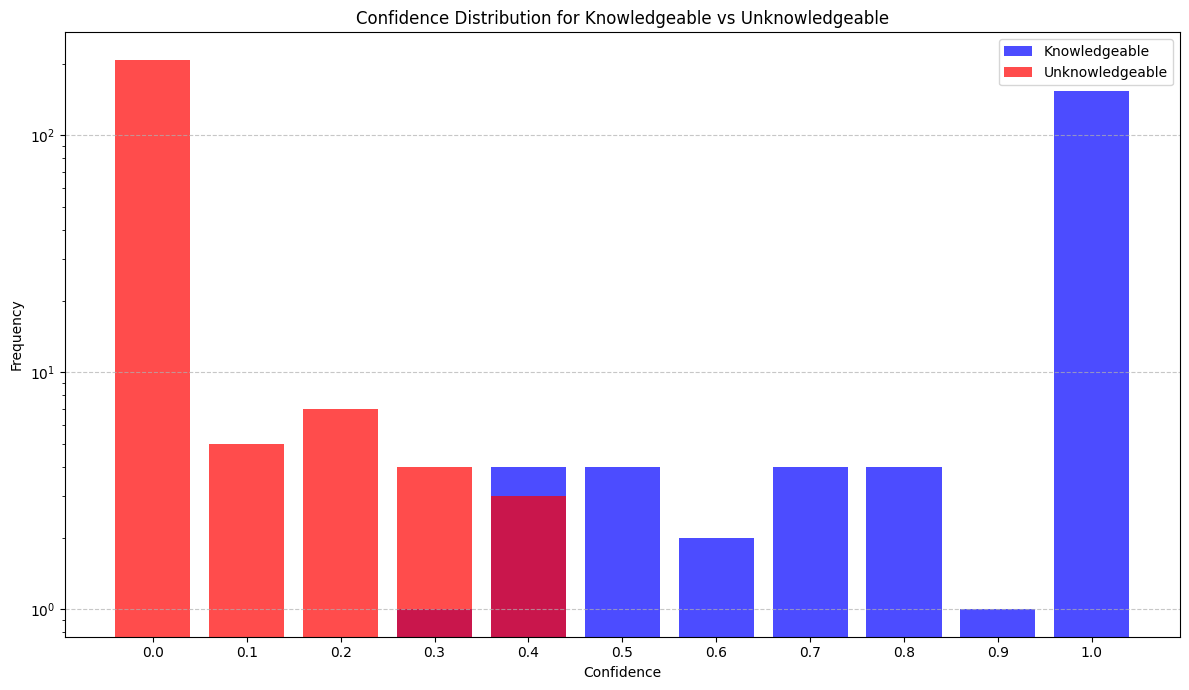

In [4]:
import numpy as np
import matplotlib.pyplot as plt

knowledgable_confidence = []
unknowledgable_confidence = []

for item in data:
    if item['knowledgable']:
        knowledgable_confidence.append(item['knowledge_confidence'])
    else:
        unknowledgable_confidence.append(item['knowledge_confidence'])

# --- Solution for discrete bins ---
# Your discrete values are 0, 0.1, 0.2, ..., 1.0 (11 distinct values).
# To center histogram bars on these values, we need bin edges halfway between them.
# For a value 'v', the bin should span from 'v - 0.05' to 'v + 0.05'.
# So, the edges will be: -0.05, 0.05, 0.15, ..., 0.95, 1.05.
# This creates 11 bins, each 0.1 wide.
bin_edges = np.arange(-0.05, 1.15, 0.1)
# print(f"Bin edges: {bin_edges}") # For verification: [-0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05]

plt.figure(figsize=(12, 7)) # Adjusted figure size for better readability

# Plot histogram for 'knowledgable_confidence'
plt.hist(knowledgable_confidence,
         bins=bin_edges,          # Use the custom bin edges
         alpha=0.7,               # Transparency
         label='Knowledgeable',
         color='blue',
         rwidth=0.8)              # Reduce bar width slightly to create small gaps if desired

# Plot histogram for 'unknowledgable_confidence'
plt.hist(unknowledgable_confidence,
         bins=bin_edges,          # Use the same custom bin edges
         alpha=0.7,               # Transparency
         label='Unknowledgeable',
         color='red',
         rwidth=0.8)              # Reduce bar width slightly

plt.title('Confidence Distribution for Knowledgeable vs Unknowledgeable')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

# Set x-axis ticks to be the center of the bins (your discrete values)
tick_centers = np.arange(0, 1.1, 0.1) # These are your actual discrete values: [0.  0.1 0.2 ... 1. ]
plt.xticks(tick_centers, [f"{x:.1f}" for x in tick_centers]) # Format ticks to one decimal place
plt.yscale('log') # Set y-axis to logarithmic scale for better visibility of lower frequencies

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid for easier frequency reading
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping
plt.show()